In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("/content/drive/MyDrive/NLP/lab_3")

## Lab 3. Clasificarea textelor utilizând vectorizarea Bag-of-Words

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### 1. Bag-of-Words

Am văzut în laboratorul trecut cum putem folosi diverse tehnici pentru a reduce un text la o listă de cuvinte (tokens). Am văzut cum putem elimina cuvintele care au o încărcătura semantică redusă (stopwords) și cum putem normaliza tokenii, aducandu-i la o forma unica pentru inlfexiuni diferite ale acestora (lematizare, stemming).

Pentru a antrena un model de Machine Learning avem nevoie să mai facem cațiva pași. Aceste reprezentari determinate anterior (liste de tokens) trebuie traduse în reprezentări numerice vectoriale (fiecarui text îi vom asocia un vector, iar toți vectorii corespunzători textelor vor avea aceeași dimensiune).

O astfel de metoda este reprezentarea textelor folosind tehnica Bag-of-Words. Aceasta metodă pornește de la un vocabular de cuvinte, un șir $[w_1, w_2, \ldots, w_n]$, unde $w_i$ reprezintă un cuvânt din vocabular. Vocabularul poate fi stabilit de la început sau determinat pe baza listelor preprocesate de tokeni (putem defini vocabularul ca cei mai frecventi $n$ tokens din aceste liste).

Un text (lista de tokens) poate fi acum transformat intr-un vector de dimensiune $n$: $(a_1, \ldots, a_n)$ unde $a_i=1$ daca cuvântul $w_i$ apare cel pușin o dată în text, respectiv $a_i=0$ altfel. Aceasta reprezentare o mai numim și Bag-of-Words binar.

O altfel de reprezentare asemanatoare poate fi bazata pe frecvente, unde $a_i$ reprezintă numărul de apariții ale cuvantului $w_i$ în text.

In [ ]:
# exemplu texte (procesate ca liste de tokens)
texts = [
    ["love", "fun", "fun", "play", "happy", "sad"],
    ["love", "happy", "love", "love", "tears"],
    ["sad", "tears", "tears"],
]

# exemplu vocabular
vocab = ["love", "fun", "tears", "sad", "happy"]

In [ ]:
# reprezentare BoW binar
repr_bin = [
    [1, 1, 0, 1, 1],
    [1, 0, 1, 0, 1],
    [0, 0, 1, 1, 0],
]

In [ ]:
# reprezentare BoW pe baza de frecvente
repr_fr = [
    [1, 2, 0, 1, 1],
    [3, 0, 1, 0, 1],
    [0, 0, 2, 1, 0],
]

Această logică poate fi implementată ușor, dar aceasta poate fi regasită (împreună cu alte detalii interesante) în clasa [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) din scikit-learn.

Într-un obiect de acest tip putem încorpora și logica de preprocesare + tokenizare a textelor.

In [ ]:
texts = [
    "Love fun fun Play Happy sad",
    "love happy Love love tears",
    "sad Tears tears",
]

Implementăm o preprocesare rudimentară a acestor texte, transformăm toate majusculele în litere mici, iar pentru tokenizare dăm split dupa spațiu. În cazul în care lucrați cu texte mai complexe, în acești pași puteți include ce am discutat în laboratorul anterior (eliminare de punctuatie, tokenizare, eliminare de stopwords, lematizare, stemming etc.).

In [ ]:
def dummy_preprocess(text):
    return text.lower()

def dummy_tokenize(text):
    return text.split(" ")

test_preprocess = dummy_preprocess(texts[0])
test_tokens = dummy_tokenize(test_preprocess)
print(test_tokens)

['love', 'fun', 'fun', 'play', 'happy', 'sad']


In [ ]:
cv = CountVectorizer(
    preprocessor=dummy_preprocess,  # metoda de preprocesare a textelor
    tokenizer=dummy_tokenize,       # metoda de tokenizare
    token_pattern=None,             # nu avem nevoie de acest argument intrucat avem propria metoda de tokenizare
    max_features=5,                 # dimensiunea maximă a vocabularului care va fi determinat
    binary=True,                    # BoW binar
)

# metoda `fit` este folosita in acest caz pentru a determina vocabularul
# (pastrand cei mai frecventi `max_features` tokens din textele procesate)
cv.fit(texts)

print(sorted(list(cv.vocabulary_.keys())))

# calculeaza reprezentarile textelor (feature vectors)
features = cv.transform(texts)
print(features.shape)
print(type(features))
print(features.toarray())  # convertim la numpy array

['fun', 'happy', 'love', 'sad', 'tears']
(3, 5)
<class 'scipy.sparse._csr.csr_matrix'>
[[1 1 1 1 0]
 [0 1 1 0 1]
 [0 0 0 1 1]]


In [ ]:
cv = CountVectorizer(
    preprocessor=dummy_preprocess, 
    tokenizer=dummy_tokenize,       
    token_pattern=None,             
    max_features=5,                 
    binary=False,                   # BoW bazat pe frecvente
)

cv.fit(texts)

print(sorted(list(cv.vocabulary_.keys())))

# calculeaza reprezentarile textelor (feature vectors)
features = cv.transform(texts)
print(features.shape)
print(type(features))
print(features.toarray())  # convertim la numpy array

['fun', 'happy', 'love', 'sad', 'tears']
(3, 5)
<class 'scipy.sparse._csr.csr_matrix'>
[[2 1 1 1 0]
 [0 1 3 0 1]
 [0 0 0 1 2]]


O alternativă a acestor reprezentări este numărarea n-gramelor.

Sa luam spre exemplu fraza "I am not happy". Metoda de mai devreme ne reda reprezentarea acestei fraza ca o multime de cuvinte (indiferent de ordinea lor). Astfel, această reprezentare indica prezența cuvantului "happy", ceea ce ar face un model să interpreteze textul într-un cadru pozitiv. Dar vedem clar că nu este aceasta situația. Dacă în loc de tokeni simpli (unigrame) am număra secvențe de cțte 2 tokeni consecutivi (bigrame), am putea identifica prezența bigramei ("not", "happy") care intuim că nu ar avea ce căuta într-un text cu sentiment pozitiv.

In [ ]:
cv = CountVectorizer(
    preprocessor=dummy_preprocess, 
    tokenizer=dummy_tokenize,       
    token_pattern=None,             
    max_features=5,                 
    ngram_range=(2, 2),                   # construim un vocabular de bigrame
)

cv.fit(texts)

print(sorted(list(cv.vocabulary_.keys())))

# calculeaza reprezentarile textelor (feature vectors)
features = cv.transform(texts)
print(features.shape)
print(type(features))
print(features.toarray())  # convertim la numpy array

['fun fun', 'fun play', 'happy love', 'happy sad', 'love fun']
(3, 5)
<class 'scipy.sparse._csr.csr_matrix'>
[[1 1 0 1 1]
 [0 0 1 0 0]
 [0 0 0 0 0]]


### 2. Feature Scaling (normalizarea datelor)

#### Standard Scaling

Având determinați vectorii de features se pune urmatoarea problemă: știind că un feature reprezintă frecventa unui cuvânt din vocabular în texte (în vectorizarea BoW), iar pentru anumite cuvinte în mod natural această frecvență este mai mare, faptul că anumite feature-uri au valoare absolută mai mare decât alta poate influența diverși algoritmi de ML să trateze acele feature-uri cu mai multa importanță (ceea ce de multe ori nu este corect).

Prin Standard Scaling presupunem că fiecare feature corespunde câte unei variabile aleatoare distribuita normal. Putem deci estima pentru fiecare astfel de variabilă media si deviatia standard, apoi prin procesul de standardizare putem reduce valorile feature-ului corespunzător la o distribuție normală de medie $0$ și varianță $1$.

In [ ]:
x_train = np.array([[1, -1, 2], [2, 0, 0], [0, 1, -1]], dtype=np.float64)
x_test = np.array([[-1, 1, 0]], dtype=np.float64)
 
# clasa folosita pentru standardizare
scaler = preprocessing.StandardScaler()

# calculam media si deviatia standard pentru feature vectorii de antrenare
scaler.fit(x_train)

print('media =', scaler.mean_)  
print('std =', scaler.scale_) 

# scalam vectorii de train
scaled_x_train = scaler.transform(x_train)
print(scaled_x_train)  

# scalam vectorii de test
# (folosim media si std determinate din train, datele de test nu sunt folosite pentru a determina hiperparametrii)
scaled_x_test = scaler.transform(x_test)
print(scaled_x_test)     

media = [1.         0.         0.33333333]
std = [0.81649658 0.81649658 1.24721913]
[[ 0.         -1.22474487  1.33630621]
 [ 1.22474487  0.         -0.26726124]
 [-1.22474487  1.22474487 -1.06904497]]
[[-2.44948974  1.22474487 -0.26726124]]


#### Normalizare L1 si L2

Acest mod de normalizare este mai simplu întrucât nu mai necesită determinarea unor parametri. Fiecare vector de features este împărțit prin norma sa (L1 sau L2), obținând astfel ca toți vectorii corespunzătoari textelor să aibă norma 1.

$$x{\_}scaled_1 = \frac{X}{\mid\mid X \mid\mid_1}, \mid\mid X \mid\mid_1 = \sum_{i=1}^{n}\mid x_i \mid $$
$$x{\_}scaled_2 = \frac{X}{\mid\mid X \mid\mid_2}, \mid\mid X \mid\mid_2 = \sqrt{\sum_{i=1}^{n} x_i ^ 2 }$$

In [ ]:
x_train = np.array([[1, -1, 2], [2, 0, 0], [0, 1, -1]], dtype=np.float64)
x_test = np.array([[-1, 1, 0]], dtype=np.float64)

# clasa folosita pentru normalizare
scaler = preprocessing.Normalizer(norm='l1') 
# scaler = preprocessing.Normalizer(norm='l2')

scaler.fit(x_train)

# scalam vectorii de train
scaled_x_train = scaler.transform(x_train)
print(scaled_x_train)  

# scalam vectorii de test
scaled_x_test = scaler.transform(x_test)
print(scaled_x_test)  

[[ 0.25 -0.25  0.5 ]
 [ 1.    0.    0.  ]
 [ 0.    0.5  -0.5 ]]
[[-0.5  0.5  0. ]]


### 3. Tf-Idf

O altă metodă de normalizare a feature-urilor pentru reprezentarea Bag-of-Words este **Tf-Idf**.

**Term Frequency (TF)** numară pentru un token și un document de câte ori apare tokenul respectiv în document.

O varianta de calcul pentru un token $t$ și un document $d$ ar fi: $\textrm{tf}(t, d) = log(1 + \textrm{frecv}(t, d))$.

**Inverse Document Frequency (IDF)** iluestrează cât de comun sau rar este un cuvânt într-un întreg corpus (mulțime de texte). Astfel, cu cât această valoare se apropie de $0$ tokenul respectiv este mai comun.

Pentru un token $t$ și o mulțime de $N$ documente $D$, putem calcula IDF astfel: $\textrm{idf}(t, D) = \log(\frac{N}{|\{d \in D: t \textrm{ apare in } d\}|})$.

**TF-IDF** combina cele doua formule:
$$\textrm{tfidf}(t, d, D) = \textrm{tf}(t, d) \cdot \textrm{idf}(t, D)$$.

Mai multe informatii [aici](https://ro.wikipedia.org/wiki/Tf%E2%80%93idf).

In [ ]:
# exemplu TfidfVectorizer

cv = TfidfVectorizer(
    preprocessor=dummy_preprocess, 
    tokenizer=dummy_tokenize,       
    token_pattern=None,             
    max_features=5,
)

cv.fit(texts)

print(sorted(list(cv.vocabulary_.keys())))

# calculeaza reprezentarile textelor (feature vectors)
features = cv.transform(texts)
print(features.shape)
print(type(features))
print(features.toarray())  # convertim la numpy array

['fun', 'happy', 'love', 'sad', 'tears']
(3, 5)
<class 'scipy.sparse._csr.csr_matrix'>
[[0.83513325 0.31757018 0.31757018 0.31757018 0.        ]
 [0.         0.30151134 0.90453403 0.         0.30151134]
 [0.         0.         0.         0.4472136  0.89442719]]


### 4. Clasificare folosind Scikit-Learn

In [ ]:
# generam o problema "dummy" de clasificare:
# - 1000 de feature vectori de dimensiune 10 (din care doar 5 sunt relevanti pentru clasificare)
# - fiecarui vector ii este asociat un label (0, 1 sau 2)
X, y = make_classification(
    n_samples=1000, n_classes=3, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 10) (800,)
(200, 10) (200,)


Vom folosi pentru clasificare un decision tree (mai multe detalii [aici](https://en.wikipedia.org/wiki/Decision_tree_learning))

In [ ]:
# initializam un astfel de algoritm cu anumiti hiperparametri
clf = DecisionTreeClassifier(max_depth=3, min_samples_split=5)

# antrenam folosind datele de train
clf.fit(X_train, y_train)

# folosim modelul pentru a prezice labelurile de test
y_test_predict = clf.predict(X_test)

### 5. Metrici

Avem la dispoziție mai multe metrici pe care le putem folosi pentru a determina performanța unui astfel de model. Să pornim mai întâi de la cazul simplu al unei probleme de clasificare binară (0/1).

In [ ]:
y_true    = [0, 0, 0, 1, 1, 1, 1]
y_predict = [0, 1, 0, 0, 1, 1, 0]

Definim:
 * TP (true positive): numărul de labeluri 1 prezise corect
 * FP (false positive): numărul de labeluri 1 prezise incorect
 * TN (true negative): numărul de labeluri 0 prezise corect
 * FN (false negative): numărul de labeluri 0 prezise incorect
 
Acuratețea se calculează după formula:
$$\frac{TP+TN}{TP+FP+TN+FN}$$

Cu alte cuvinte, numărul total de labeluri prezise corect din totalul de predicții.

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_true, y_predict))

Accuracy: 0.5714285714285714


Acuratețea nu este mereu cea mai bună metrică de urmărit atunci când vrem să apreciem cât de bun este un model. De exemplu, in cazul unui dataset dezechilibrat (imbalanced), în care $99\%$ din obiecte au labelul $0$ și doar $1\%$ au labelul $1$, un clasificator care prezice doar labelul $0$ pentru toate exemplele ar avea acuratete $99\%$! Dacă problema ar fi fost detectarea de spam, sau detectarea simptomelor asociate unui anumit tip de cancer, un astfel de model nu ar fi considerat unul performant.

Introducem astfel alte cateva metrici:
 * P (precision): $\frac{TP}{TP+FP}$ (dintre toate predictiile 1, cate sunt corecte?)
 * R (recall): $\frac{TP}{TP+FN}$ (dintre toate obiectele din clasa 1, cate am reusit sa prezicem corect?)
 * F1: $\frac{2PR}{P+R}$ (media armonica intre precision si recall)

 Un clip explicativ aici: https://youtu.be/qWfzIYCvBqo

In [ ]:
print("Precision:", metrics.precision_score(y_true, y_predict))
print("Recall:", metrics.recall_score(y_true, y_predict))
print("F1:", metrics.f1_score(y_true, y_predict))

Precision: 0.6666666666666666
Recall: 0.5
F1: 0.5714285714285715


În cazul problemelor de clasificare de tip multi-class (mai mult de 2 clase), acuratețea păstrează același sens de "câte predicții sunt corecte din totalul predicțiilor".

Precision, Recall și F1 se calculează într-o manieră *one-vs-rest*. Astfel, fixând o anumită clasă, transformăm labelurile în $1$ dacă labelul original corespunde clasei fixate și $0$ altfel. Putem acum calcula aceste metrici în cazul binar. Rezultatele obținute pentru fiecare astfel de fixare vor fi acumulate și rezultatul final este media acestora (calculată ca medie aritmetică - macro, sau ca medie ponderată - weighted, în care ponderile sunt date de numărul de exemple din clasa respectivă).

In [ ]:
# calculam acuratete si F1 pentru clasificarea de mai devreme
print("Accuracy:", metrics.accuracy_score(y_test, y_test_predict))
print("F1 (macro):", metrics.f1_score(y_test, y_test_predict, average="macro"))
print("F1 (weighted):", metrics.f1_score(y_test, y_test_predict, average="weighted"))

Accuracy: 0.7
F1 (macro): 0.6935607271177741
F1 (weighted): 0.6932996310177518


In [ ]:
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76        68
           1       0.67      0.86      0.75        65
           2       0.65      0.51      0.57        67

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.70      0.70      0.69       200



O vizualizare utilă este și **matricea de confuzie**, în care numărăm $A[i][j]$ câte obiecte din clasa $i$ au fost prezise ca facând parte din clasa $j$.

In [ ]:
cm = metrics.confusion_matrix(y_test, y_test_predict)
print(cm)

[[50  7 11]
 [ 2 56  7]
 [12 21 34]]


<AxesSubplot:>

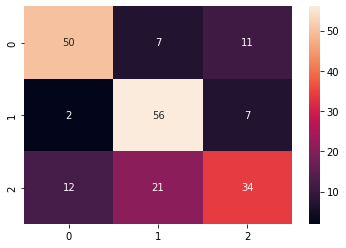

In [ ]:
sns.heatmap(cm, annot=True)

### 6. Importanța feature-urilor

Intuitiv, anumite feature-uri sunt mai importante decât altele când vine vorba de clasificare. De exemplu, prezența cuvântului "happy" sau "sad" ne poate oferi informații despre sentimentul unui text, pe cand cuvantul "car", nu.

Feature: 0, Score: 0.11837956006934854
Feature: 1, Score: 0.0
Feature: 2, Score: 0.4172424563910119
Feature: 3, Score: 0.039030730202152863
Feature: 4, Score: 0.0
Feature: 5, Score: 0.21084131505634365
Feature: 6, Score: 0.0
Feature: 7, Score: 0.04661388817258808
Feature: 8, Score: 0.06021961536405184
Feature: 9, Score: 0.10767243474450318


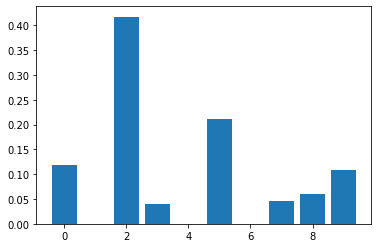

In [ ]:
# pentru decision tree avem urmatoare metoda pentru a extrage aceasta importanta
importance = clf.feature_importances_
for i,v in enumerate(importance):
    print(f"Feature: {i}, Score: {v}")

plt.bar([x for x in range(len(importance))], importance)
plt.show()

Pentru alte modele există diverse alte moduri de a extrage importanța feature-urilor (ex. logistic regression, SVM linear, Random Forest etc.), însă pentru altele este mult mai complicat sau chiar imposibil (ex. SVM cu kernel RBF).

# TASK:

### Deadline: 26 martie ora 23:59.
### Formular pentru trimiterea temei: https://forms.gle/ZNPxW6Twm52T94HcA

Vom folosi urmatorul dataset: https://www.kaggle.com/rmisra/news-category-dataset (headline-uri de stiri etichetate conform unei liste de categorii).

1. (opțional) Întrucît setul de date conține multe categorii, puteți păstra doar exemple din 4-5 clase (selectate de voi) și să rezolvați problema de clasificare doar pentru aceste exemple.

In [43]:
import pandas as pd
import re
import emoji
import spacy

In [28]:


df = pd.read_json('News_Category_Dataset_v3.json',lines = True)
#display(df.head())
# categories = df['category'].unique()
# print(categories)
categories = ['CRIME','COMEDY', 'RELIGION', 'POLITICS']
df = df[df['category'].isin(categories)]
display(df.head())

texts = df['short_description'].array



,link,headline,category,short_description,authors,date
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
21,https://www.huffpost.com/entry/biden-us-forces...,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,President issues vow as tensions with China rise.,,2022-09-19
24,https://www.huffpost.com/entry/ukraine-festiva...,‘Beautiful And Sad At The Same Time’: Ukrainia...,POLITICS,An annual celebration took on a different feel...,Jonathan Nicholson,2022-09-19
30,https://www.huffpost.com/entry/europe-britain-...,Biden Says Queen's Death Left 'Giant Hole' For...,POLITICS,"U.S. President Joe Biden, in London for the fu...","Darlene Superville, AP",2022-09-18
40,https://www.huffpost.com/entry/afghan-adjustme...,Bill To Help Afghans Who Escaped Taliban Faces...,POLITICS,Republican outrage over the shoddy U.S. withdr...,Hamed Ahmadi and Arthur Delaney,2022-09-16


In [58]:

list(texts)

['"Until you have a dog you don\'t understand what could be eaten."',
 'President issues vow as tensions with China rise.',
 "An annual celebration took on a different feel as Russia's invasion dragged into Day 206.",
 'U.S. President Joe Biden, in London for the funeral of Queen Elizabeth II, says his heart went out to the royal family, adding the queen’s death left a “giant hole.”.',
 'Republican outrage over the shoddy U.S. withdrawal from Afghanistan hasn’t spurred support for resettling refugees.',
 'The former White House chief of staff has turned over records as part of a federal investigation into the Jan. 6, 2021 assault on the Capitol.',
 "The state's general treasurer is slated to face former Cranston Mayor Allan Fung (R) in the general election.",
 '"Cancer does not discriminate red and blue," the president said Monday. "Beating cancer is something we can do together."',
 '"Who we have on the field is who we’re gonna play,” Scott told "Fox News Sunday."',
 'Democrats in the

In [55]:
def to_lower(array):
    texts_lower = [s.lower() for s in array]
    return texts_lower

def remove_mentions(array):
    texts_lower = [re.sub(r'@\S+','',s) for s in array]
    return texts_lower
    
# Preluat din LAB 2 optional NLP anul 3
def remove_links(texts): 
    text_no_links = [re.sub(r'http\S+', '', text) for text in texts]
    return [re.sub(r'www\S+', '', text) for text in text_no_links]

def remove_emojis(texts):
    texts_no_emoji = []
    for text in texts:
        emojis = emoji.emoji_list(text)

        text_no_emoji = text
        for emoji_dict in emojis:
            emoji_str = emoji_dict.get("emoji")
            text_no_emoji = re.sub(emoji_str, ' ', text_no_emoji)

        texts_no_emoji.append(text_no_emoji)
    return texts_no_emoji
        
def remove_punctuation(arr):
    texts_no_punct = [re.sub(r'[^\w\s]', ' ', text) for text in arr]
    return texts_no_punct


def remove_chinese_words(arr):

    chinese_pattern = re.compile(r'[\u4e00-\u9fff]+')
    new_arr = []
    for string in arr:
        new_string = chinese_pattern.sub('', string)
        new_arr.append(new_string)
    return new_arr

def remove_spaces(texts):
    texts_no_spaces = [re.sub(r'\s+', ' ', text).strip() for text in texts]
    return texts_no_spaces


def remove_numbers(texts):
    texts_no_numbers = [re.sub(r'\d', ' ', text).strip() for text in texts]
    return texts_no_numbers



def normalize_text(texts):
    texts = to_lower(texts)
    texts = remove_mentions(texts)
    texts = remove_emojis(texts)
    texts = remove_links(texts)
    texts = remove_punctuation(texts)
    texts = remove_numbers(texts)
    texts = remove_chinese_words(texts)
    texts = remove_spaces(texts)
    
    return texts

def dummy_tokenize(texts):
    return [[word for word in sentence.split()] for sentence in normalize_text(texts)]

2. Încercați mai multe metode de preprocesare și tokenizare a textelor pentru a obține reprezentări de tip Bag-of-Words (ștergeti/nu ștergeti stop words, lematizați sau aplicați stemming, păstrați sau eliminați punctuația, normalizați folosind standardizare, L1, L2 sau Tf-Idf). Implementați **3** astfel de combinații.

In [59]:

#eliminat punctuatie, to lower,  etc..
first_pre = [[word for word in sentence.split()] for sentence in normalize_text(texts)]

nlp = spacy.load("ro_core_news_sm")
stop_words = nlp.Defaults.stop_words
#print(stop_words)

second_pre = [[word for word in sentence.split() if word not in stop_words] for sentence in  normalize_text(texts)]



cv = TfidfVectorizer(
    preprocessor=normalize_text, 
    tokenizer=dummy_tokenize,       
    token_pattern=None,             
    max_features=100,
)

cv.fit(texts)
third_pre = list(cv.vocabulary_.keys())
print(sorted(list(cv.vocabulary_.keys())))

TypeError: unhashable type: 'list'

3. Împărțiți setul de date în 80% train, 20% test, iar pentru fiecare metodă de preprocesare antrenați un model ales de voi (diferit de Decision Tree) pe datele de train.

4. Evaluati modelul pe datele de test, determinând acuratețe, precizie, recall, f1, și stabiliți care metodă de procesare a textelor a adus rezultate mai bune.

5. Determinați pentru acest caz care au fost top 10 cele mai importante feature-uri (cuvinte).

6. Folosind această metodă de procesare a textelor, antrenați alte doua modele diferite la alegere și comparati performanța cu modelul original.

7. Pentru cel mai bun model afisați metricile la nivel de clasă (classification report) și matricea de confuzie.